# Assessing Read Quality

### Questions:
- How can I describe the quality of my data?
### Objectives:
- Explain how a FASTQ file encodes per-base quality scores.
- Interpret a FastQC plot summarizing per-base quality across all reads.
- Use `for` loops to automate operations on multiple files.
### Keypoints:
- It is important to know the quality of our data to make decisions in the subsequent steps.
- FastQC is a program that allows us to know the quality of FASTQ files.
- `for` loops let you perform the same operations on multiple files with a single command.

## Getting Started

In [ ]:
# set the variables for your netid
netid = "NETID"

In [ ]:
# Go into the working directory
work_dir = "/xdisk/bhurwitz/bh_class/" + netid + "/exercises/06_qc_trimming"
%cd $work_dir

In [ ]:
# Create a variable for the data directory
data_dir = "/xdisk/bhurwitz/bh_class/" + netid + "/exercises/data/untrimmed_fastq"

## Quality control

We will now assess the quality of the sequence reads contained in our FASTQ files. 

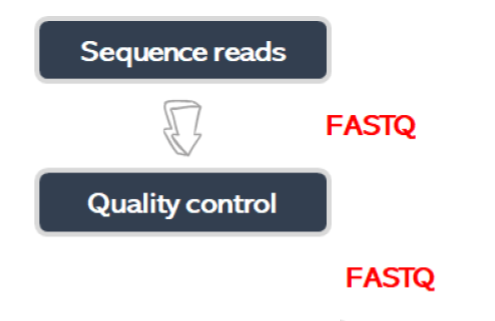

### Details on the FASTQ format

Although it looks complicated (and it is), we can understand the [FASTQ](https://en.wikipedia.org/wiki/FASTQ_format) format with a little decoding. Some rules about the format include the following:  

|Line|Description|   
|----|-----------|     
|1|Always begins with '@' followed by the information about the read|  
|2|The actual DNA sequence|  
|3|Always begins with a '+' and sometimes contains the same info as in line 1|  
|4|Has a string of characters which represent the quality scores; must have same number of characters as line 2|  

We can view the first complete read in one of the files from our dataset using `head` to look at
the first four lines. But we have to decompress one of the files first using `gzip -dc`.


In [ ]:
%cd $data_dir
!gzip -dc JP4D_R1.fastq.gz | head


```
@MISEQ-LAB244-W7:156:000000000-A80CV:1:1101:12622:2006 1:N:0:CTCAGA
CCCGTTCCTCGGGCGTGCAGTCGGGCTTGCGGTCTGCCATGTCGTGTTCGGCGTCGGTGGTGCCGATCAGGGTGAAATCCGTCTCGTAGGGGATCGCGAAGATGATCCGCCCGTCCGTGCCCTGAAAGAAATAGCACTTGTCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCTCAGAATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAGCAAACCTCTCACTCCCTCTACTCTACTCCCTT                                        
+                                                                                                
A>>1AFC>DD111A0E0001BGEC0AEGCCGEGGFHGHHGHGHHGGHHHGGGGGGGGGGGGGHHGEGGGHHHHGHHGHHHGGHHHHGGGGGGGGGGGGGGGGHHHHHHHGGGGGGGGHGGHHHHHHHHGFHHFFGHHHHHGGGGGGGGGGGGGGGGGGGGGGGGGGGGFFFFFFFFFFFFFFFFFFFFFBFFFF@F@FFFFFFFFFFBBFF?@;@#################################### 
```

Line 4 shows the quality of each nucleotide in the read. Quality is interpreted as the probability of an incorrect base call (e.g., 1 in 10) or, equivalently, the base call accuracy (e.g., 90%). Each nucleotide's numerical score's value is converted into a character code where every single character represents a quality score for an individual nucleotide. This conversion allows the alignment of each individual nucleotide with its quality
score. For example, in the line above, the quality score line is: 

```
A>>1AFC>DD111A0E0001BGEC0AEGCCGEGGFHGHHGHGHHGGHHHGGGGGGGGGGGGGHHGEGGGHHHHGHHGHHHGGHHHHGGGGGGGGGGGGGGGGHHHHHHHGGGGGGGGHGGHHHHHHHHGFHHFFGHHHHHGGGGGGGGGGGGGGGGGGGGGGGGGGGGFFFFFFFFFFFFFFFFFFFFFBFFFF@F@FFFFFFFFFFBBFF?@;@#################################### 
```

The numerical value assigned to each character depends on the sequencing platform that generated the reads. The sequencing machine used to generate our data uses the standard Sanger quality PHRED score encoding, using Illumina version 1.8 onwards.
Each character is assigned a quality score between 0 and 41, as shown in the chart below.

```
Quality encoding: !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJ
                   |         |         |         |         |
Quality score:    01........11........21........31........41                                
```


Each quality score represents the probability that the corresponding nucleotide call is
incorrect. These probability values are the results of the base calling algorithm and depend on how 
much signal was captured for the base incorporation. This quality score is logarithmically based, so a quality score of 10 reflects a
base call accuracy of 90%, but a quality score of 20 reflects a base call accuracy of 99%. 
In this [link](https://drive5.com/usearch/manual/quality_score.html) you can find more information 
about quality scores.

Looking back at our read: 

```
@MISEQ-LAB244-W7:156:000000000-A80CV:1:1101:12622:2006 1:N:0:CTCAGA
CCCGTTCCTCGGGCGTGCAGTCGGGCTTGCGGTCTGCCATGTCGTGTTCGGCGTCGGTGGTGCCGATCAGGGTGAAATCCGTCTCGTAGGGGATCGCGAAGATGATCCGCCCGTCCGTGCCCTGAAAGAAATAGCACTTGTCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCTCAGAATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAGCAAACCTCTCACTCCCTCTACTCTACTCCCTT                                        
+                                                                                                
A>>1AFC>DD111A0E0001BGEC0AEGCCGEGGFHGHHGHGHHGGHHHGGGGGGGGGGGGGHHGEGGGHHHHGHHGHHHGGHHHHGGGGGGGGGGGGGGGGHHHHHHHGGGGGGGGHGGHHHHHHHHGFHHFFGHHHHHGGGGGGGGGGGGGGGGGGGGGGGGGGGGFFFFFFFFFFFFFFFFFFFFFBFFFF@F@FFFFFFFFFFBBFF?@;@#################################### 
```

We can now see that there is a range of quality scores but that the end of the sequence is very poor (`#` = a quality score of 2). 

> ## Exercise 1: Looking at specific reads  
> 
> In the terminal, how would you show the ID and quality of the last read `JP4D_R1.fastq`?  
> a) `tail JP4D_R1.fastq`  
> b) `head -n 4 JP4D_R1.fastq`  
> c) `more JP4D_R1.fastq`  
> d) `tail -n4 JP4D_R1.fastq`  
> e) `tail -n4 JP4D_R1.fastq | head -n2`  
>   
>   Do you trust the sequence in this read? 

<details>
  <summary markdown="span">Solution</summary>
  <ul>
  
 a) It shows the ID and quality of the last read but also unnecessary lines from previous reads.  
 b) No. It shows the first read's info.  
 c) It shows the text of the entire file.  
 d) This option is the best answer as it only shows the last read's information.  
 e) It does show the ID of the last read but not the quality.  
 

```
@MISEQ-LAB244-W7:156:000000000-A80CV:1:2114:17866:28868 1:N:0:CTCAGA

CCCGTTCTCCACCTCGGCGCGCGCCAGCTGCGGCTCGTCCTTCCACAGGAACTTCCACGTCGCCGTCAGCCGCGACACGTTCTCCCCCCTCGCATGCTCGTCCTGTCTCTCGTGCTTGGCCGACGCCTGCGCCTCGCACTGCGCCCGCTCGGTGTCGTTCATGTTGATCTTCACCGTGGCGTGCATGAAGCGGTTCCCGGCCTCGTCGCCACCCACGCCATCCGCGTCGGCCAGCCACTCTCACTGCTCGC

+

AA11AC1>3@DC1F1111000A0/A///BB#############################################################################################################################################################################################################################          
```

This read has more consistent quality at its first than at the end
but still has a range of quality scores, 
most of them are low. We will look at variations in position-based quality in just a moment.

</details>

#### In real life...

In real life, you won't be assessing the quality of your reads by visually inspecting your FASTQ files. Instead, you'll use a software program to assess read quality and filter out poor reads. We'll first use a program called [FastQC](http://www.bioinformatics.babraham.ac.uk/projects/fastqc/) to visualize the quality of our reads. 
Later in our class, we'll use another program to filter out poor-quality reads called trimmomatic

## Using fastqc to look at quality

First, let's see if you can use fastqc from a container on the HPC. Let's get a help message from FastQC to make sure we can run this tool.

In [ ]:
!apptainer run /contrib/singularity/shared/bhurwitz/fastqc-0.11.9.sif fastqc -h

#### You should see something like this

```
            FastQC - A high throughput sequence QC analysis tool

SYNOPSIS

        fastqc seqfile1 seqfile2 .. seqfileN

    fastqc [-o output dir] [--(no)extract] [-f fastq|bam|sam]
           [-c contaminant file] seqfile1 .. seqfileN

DESCRIPTION

    FastQC reads a set of sequence files and produces from each one a quality
    control report consisting of many different modules, each one of
    which will help to identify a different potential type of problem in your
    data.
.
.
.
```

## Assessing quality using FastQC

FastQC has several features that can give you a quick impression of any problems your data may have, so you can consider these issues before moving forward with your analyses. Rather than looking at quality scores for each read, FastQC looks at quality collectively across all reads within a sample. The image below shows one FastQC-generated plot that indicates a very high-quality sample:

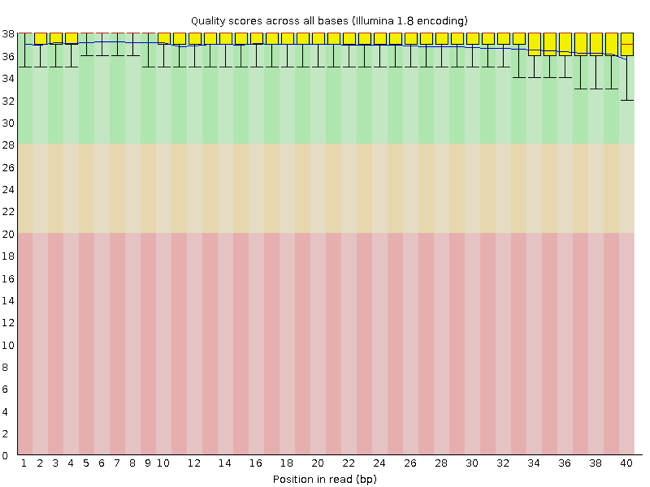

Quality graph showing a boxplot for each sequence position in the x-axis, and the Phred score in the y-axis. The background is colored red for the Phred scores 0 to 20, yellow for the scores 20 to 28, and green for the scores 28 to 38. All of the boxes for each position are in the green area.

The x-axis displays the base position in the read, and the y-axis shows quality scores. In this example, the sample contains reads that are 40 bp long. This length is much shorter than the reads we are working on within our workflow. For each position, there is a box-and-whisker plot showing the distribution of quality scores for all reads at that position. The horizontal red line indicates the median quality score, and the yellow box shows the 1st to 3rd quartile range. This range means that 50% of reads have a quality score that falls within the range of the yellow box at that position. The whiskers show the whole range covering the lowest (0th quartile) to highest (4th quartile) values.

The quality values for each position in this sample do not drop much lower than 32, which is a high-quality score. The plot background is also color-coded to identify good (green),
acceptable (yellow) and bad (red) quality scores.


Now let's look at a quality plot on the other end of the spectrum. 

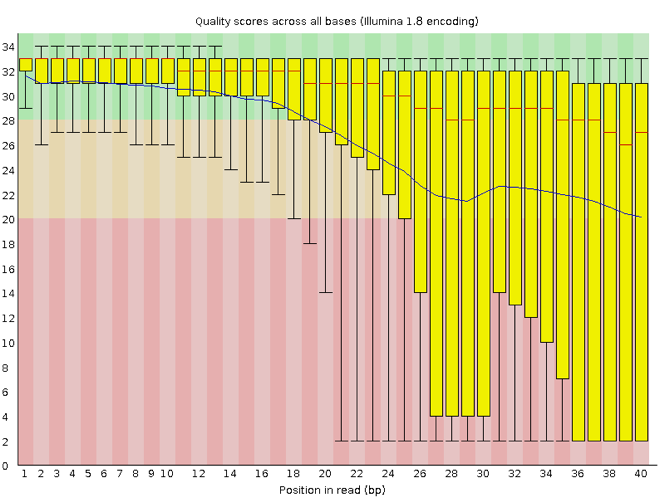

Graphic of boxplots, where the first ones are in the good range of scores of the y-axis and extend to the acceptable and bad ranges of scores toward the right of the x-axis

The FastQC tool produces several other diagnostic plots to assess sample quality and the one plotted above. Here, we see positions within the read in which the boxes span a much more comprehensive range. Also, quality scores drop pretty low into the "bad" range, particularly on the tail end of the reads. 

## Running FastQC  

We will now assess the quality of the reads that we downloaded. First, make sure you're still in the `untrimmed_fastq` directory.

In [ ]:
%cd $data_dir

> ## Exercise 2: Looking at metadata about the untrimmed-files
> 
> To know which files have more data, you need to see metadata about untrimmed files. In files, metadata includes owners of the file, state of the write, read, and execute permissions, size, and modification date. Using the `ls` command, how would you get the size of the files in the `untrimmed_fastq\` directory?  
> (Hint: Look at the options for the `ls` command to see how to show file sizes.)  
> a) `ls -a`  
> b) `ls -S`  
> c) `ls -l`  
> d) `ls -lh`  
> e) `ls -ahlS`  
>   
<details>
  <summary markdown="span">Solution</summary>
  <ul> 

``` 
a) No. The flag `-a` shows all the contents, including hidden files and directories, but not the sizes.  
b) No. The flag `-S` shows the content Sorted by size, starting with the most extensive file, but not the sizes.  
c) Yes. The flag `-l` shows the contents with metadata, including file size. Other metadata are permissions, owners, and modification dates.    
d) Yes. The flag `-lh` shows the content with metadata in a human-readable manner.  
e) Yes. The combination of all the flags shows all the contents with metadata, including hidden files, sorted by size.  
```


______________

In [ ]:
!ls -ahls

```
-rw-r--r-- 1 user user  24M Nov 26 21:34 JC1A_R1.fastq.gz                      
-rw-r--r-- 1 user user  24M Nov 26 21:34 JC1A_R2.fastq.gz                      
-rw-r--r-- 1 user user 616M Nov 26 21:34 JP4D_R1.fastq              
-rw-r--r-- 1 user user 203M Nov 26 21:35 JP4D_R2.fastq.gz   
```

Four FASTQ files range between 24M (24MB) to 616M. The largest file is JP4D_R1.fastq with 616M. 

FastQC can accept multiple file names as input, and on both zipped and unzipped files, 
so we can use the `\*.fastq*`wildcard to run FastQC on all FASTQ files in this directory.

In [ ]:
!apptainer run /contrib/singularity/shared/bhurwitz/fastqc-0.11.9.sif fastqc *.fastq*

You will see an automatically updating output message telling you the 
progress of the analysis. It will start like this: 

```
Started analysis of JC1A_R1.fastq.gz                                               
Approx 5% complete for JC1A_R1.fastq.gz                                            
Approx 10% complete for JC1A_R1.fastq.gz                                           
Approx 15% complete for JC1A_R1.fastq.gz                                           
Approx 20% complete for JC1A_R1.fastq.gz                                           
Approx 25% complete for JC1A_R1.fastq.gz                                           
Approx 30% complete for JC1A_R1.fastq.gz                                          
Approx 35% complete for JC1A_R1.fastq.gz  
```

It should take around five minutes for FastQC to run on all
four of our FASTQ files. When the analysis completes, your prompt
will return. So your screen will look something like this:

```
Approx 80% complete for JP4D_R2.fastq.gz
Approx 85% complete for JP4D_R2.fastq.gz
Approx 90% complete for JP4D_R2.fastq.gz
Approx 95% complete for JP4D_R2.fastq.gz
Analysis complete for JP4D_R2.fastq.gz
$
```

The FastQC program has created several new files within our
`data/untrimmed_fastq/` directory. 

In [ ]:
!ls

#### You should see something like this

```
JC1A_R1_fastqc.html  JC1A_R2_fastqc.html  JP4D_R1.fastq        JP4D_R2_fastqc.html  TruSeq3-PE.fa
JC1A_R1_fastqc.zip   JC1A_R2_fastqc.zip   JP4D_R1_fastqc.html  JP4D_R2_fastqc.zip
JC1A_R1.fastq.gz     JC1A_R2.fastq.gz     JP4D_R1_fastqc.zip   JP4D_R2.fastq.gz    
```

For each input FASTQ file, FastQC has created a `.zip` file and a
`.html` file. The `.zip` file extension indicates that this is 
a compressed set of multiple output files. We'll be working
with these output files soon. The `.html` file is a stable webpage
displaying the summary report for each of our samples.

We want to keep our data files and our results files separate, so we
will move these output files into our results directory.

In [ ]:
!mv *.zip $work_dir
!mv *.html $work_dir

#### Let's visualize these files

If we want to visualize these HTML files we can do so by copying them to our home directory and opening them via the Jupyter server.

First let's go to the results directory and copy the files into a directory in our home dir. 

In [ ]:
# copy the fastqc *html files to your home directory to visualize using Jupyter
%cd $work_dir
!mkdir ~/exercise_06_01_fastqc
!cp *.html ~/exercise_06_01_fastqc

## Viewing the FastQC results

By using the Jupyter server, we will be able to look at each of these HTML files by opening them in a web browser. Go to the HPC on demand site, and kick off a Jupyter notebook job. Once your instance is running, open it up and go to the exercise_06_01_fastqc folder.

Now we can open the 4 HTML files. You can double click on each html file to open it up in the web browser.

> ## Exercise 4: Discuss the quality of sequencing files
> 
> Discuss your results with a neighbor. Which sample(s) looks the best
> per base sequence quality? Which sample(s) look the
> worst?
> 
<details>
  <summary markdown="span">Solution</summary>
  <ul> 
All of the reads contain usable data, but the quality decreases toward
the end of the reads. File JC1A_R2_fastqc shows the lowest quality.
</details>

## Decoding the other FastQC outputs
We've now looked at quite a few "Per base sequence quality" FastQC graphs, but there are nine other graphs that we haven't talked about! Below we have provided a brief overview of interpretations for each plot. For more information, please see the FastQC documentation [here](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/) 

+ [**Per tile sequence quality**](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/12%20Per%20Tile%20Sequence%20Quality.html): the machines that perform sequencing are divided into tiles. This plot displays patterns in base quality along these tiles. Consistently low scores are often found around the edges, but hot spots could also occur in the middle if an air bubble was introduced during the run. 
+ [**Per sequence quality scores**](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/3%20Per%20Sequence%20Quality%20Scores.html): a density plot of quality for all reads at all positions. This plot shows what quality scores are most common. 
+ [**Per base sequence content**](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/4%20Per%20Base%20Sequence%20Content.html): plots the proportion of each base position over all of the reads. Typically, we expect to see each base roughly 25% of the time at each position, but this often fails at the beginning or end of the read due to quality or adapter content.
+ [**Per sequence GC content**](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/5%20Per%20Sequence%20GC%20Content.html): a density plot of average GC content in each of the reads.  
+ [**Per base N content**](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/6%20Per%20Base%20N%20Content.html): the percent of times that 'N' occurs at a position in all reads. If there is an increase at a particular position, this might indicate that something went wrong during sequencing.  
+ [**Sequence Length Distribution**](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/7%20Sequence%20Length%20Distribution.html): the distribution of sequence lengths of all reads in the file. If the data is raw, there is often a sharp peak; however, if the reads have been trimmed, there may be a distribution of shorter lengths. 
+ [**Sequence Duplication Levels**](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/8%20Duplicate%20Sequences.html): a distribution of duplicated sequences. In sequencing, we expect most reads to only occur once. If some sequences are occurring more than once, it might indicate enrichment bias (e.g. from PCR). This might not be true if the samples are high coverage (or RNA-seq or amplicon).  
+ [**Overrepresented sequences**](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/9%20Overrepresented%20Sequences.html): a list of sequences that occur more frequently than would be expected by chance. 
+ [**Adapter Content**](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/10%20Adapter%20Content.html): a graph indicating where adapter sequences occur in the reads.
+ [**K-mer Content**](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/11%20Kmer%20Content.html): a graph showing any sequences which may show a positional bias within the reads.

## Working with the FastQC text output

Now that we've looked at our HTML reports and are getting a feel for the data, let's look more closely at the other output files. Go back to the shell.

In [ ]:
%cd $work_dir
!ls

#### You should see something like this

```
JC1A_R1_fastqc.html           JP4D_R1_fastqc.html                  
JC1A_R1_fastqc.zip            JP4D_R1_fastqc.zip                   
JC1A_R2_fastqc.html           JP4D_R2_fastqc.html                  
JC1A_R2_fastqc.zip            JP4D_R2_fastqc.zip 
```

Our `.zip` files are compressed files. Each contains multiple 
different types of output files for a single input FASTQ file. To
view the contents of a `.zip` file, we can use the program `unzip` 
to decompress these files. Let's try doing them all at once using a
wildcard.

In [ ]:
!unzip *.zip 

#### what do you see?

```
Archive:  JC1A_R1_fastqc.zip                                                       
caution: filename not matched:  JC1A_R2_fastqc.zip                                 
caution: filename not matched:  JP4D_R1_fastqc.zip                      
caution: filename not matched:  JP4D_R2_fastqc.zip  
```


This decompression didn't work. It identified the first file and got a warning message for the other `.zip` files. This is because `unzip` 
expects to get only one zip file as input. We could go through and 
unzip each file one at a time, but this is very time-consuming and 
error-prone. Someday you may have 500 files to unzip!

A more efficient way is to use a `for` loop like we learned in the Command Line lesson to iterate through all of our `.zip` files. Let's see what that looks like, and then we'll 
discuss what we're doing with each line of our loop.

In [ ]:
# run a for loop to unzip all
!for filename in *.zip; do ; unzip $filename; done

#### What do you see?

In this example, the input is the four filenames (one filename for each of our `.zip` files).
Each time the loop iterates, it will assign a file name to the variable `filename`
and run the `unzip` command.

The first time through the loop,`$filename` is `JC1A_R1_fastqc.zip`. 

The interpreter runs the command `unzip` on `JC1A_R1_fastqc.zip`.

For the second iteration, `$filename` becomes `JC1A_R2_fastqc.zip`. This time, the shell runs `unzip` on `JC1A_R2_fastqc.zip`. It then repeats this process for the other `.zip` files in our directory.

When we run the `for` loop, you will see an output that starts like this:

```
Archive:  JC1A_R1_fastqc.zip                                            
creating: JC1A_R1_fastqc/                                            
creating: JC1A_R1_fastqc/Icons/                                      
creating: JC1A_R1_fastqc/Images/                                    
inflating: JC1A_R1_fastqc/Icons/fastqc_icon.png                      
inflating: JC1A_R1_fastqc/Icons/warning.png                          
inflating: JC1A_R1_fastqc/Icons/error.png                            
inflating: JC1A_R1_fastqc/Icons/tick.png                             
inflating: JC1A_R1_fastqc/summary.txt                                
inflating: JC1A_R1_fastqc/Images/per_base_quality.png                
inflating: JC1A_R1_fastqc/Images/per_tile_quality.png                
inflating: JC1A_R1_fastqc/Images/per_sequence_quality.png            
inflating: JC1A_R1_fastqc/Images/per_base_sequence_content.png       
inflating: JC1A_R1_fastqc/Images/per_sequence_gc_content.png         
inflating: JC1A_R1_fastqc/Images/per_base_n_content.png              
inflating: JC1A_R1_fastqc/Images/sequence_length_distribution.png 
inflating: JC1A_R1_fastqc/Images/duplication_levels.png              
inflating: JC1A_R1_fastqc/Images/adapter_content.png                 
inflating: JC1A_R1_fastqc/fastqc_report.html                         
inflating: JC1A_R1_fastqc/fastqc_data.txt                            
inflating: JC1A_R1_fastqc/fastqc.fo  
```

The `unzip` program is decompressing the `.zip` files and creates a new directory (with subdirectories) for each of our samples, to store all of the different output that is produced by FastQC. There are a lot of files here. We're going to focus on the `summary.txt` file. 

In [ ]:
# If you list the files in our directory, now you will see the following:
!ls

#### what do you see?

```
JC1A_R1_fastqc                  JP4D_R1_fastqc                                                     
JC1A_R1_fastqc.html             JP4D_R1_fastqc.html                                        
JC1A_R1_fastqc.zip              JP4D_R1_fastqc.zip                                                  
JC1A_R2_fastqc                  JP4D_R2_fastqc                                               
JC1A_R2_fastqc.html             JP4D_R2_fastqc.html                                             
JC1A_R2_fastqc.zip              JP4D_R2_fastqc.zip                                         
```

The `.html` files and the uncompressed `.zip` files are still present,
but now we also have a new directory for each sample. We can 
see that it's a directory if we use the `-F` flag for `ls`. 


In [ ]:
!ls -F 

#### What do you see?

```
JC1A_R1_fastqc/                  JP4D_R1_fastqc/                                                     
JC1A_R1_fastqc.html             JP4D_R1_fastqc.html                                        
JC1A_R1_fastqc.zip              JP4D_R1_fastqc.zip                                                  
JC1A_R2_fastqc/                  JP4D_R2_fastqc/                                               
JC1A_R2_fastqc.html             JP4D_R2_fastqc.html                                             
JC1A_R2_fastqc.zip              JP4D_R2_fastqc.zip                                         
```

In [ ]:
# Let's see what files are present within one of these output directories.
!ls -F JC1A_R1_fastqc/ 

#### What do you see?

```
fastqc_data.txt  fastqc.fo  fastqc_report.html	Icons/	Images/  summary.txt
```


In [ ]:
# USe head to preview the the `summary.txt` file for this sample.
!head JC1A_R1_fastqc/summary.txt

#### What do you see?

```
PASS    Basic Statistics        JC1A_R1.fastq.gz                     
FAIL    Per base sequence quality       JC1A_R1.fastq.gz             
PASS    Per tile sequence quality       JC1A_R1.fastq.gz             
PASS    Per sequence quality scores     JC1A_R1.fastq.gz             
WARN    Per base sequence content       JC1A_R1.fastq.gz             
FAIL    Per sequence GC content JC1A_R1.fastq.gz                     
PASS    Per base N content      JC1A_R1.fastq.gz                     
PASS    Sequence Length Distribution    JC1A_R1.fastq.gz             
FAIL    Sequence Duplication Levels     JC1A_R1.fastq.gz             
PASS    Overrepresented sequences       JC1A_R1.fastq.gz             
FAIL    Adapter Content JC1A_R1.fastq.gz  
```

The summary file gives us a list of tests that FastQC ran and tells
us whether this sample passed, failed, or is borderline (`WARN`). Remember, to quit from `less`, you must type `q`.


## Documenting our work

We can make a record of the results we obtained for all our samples
by concatenating all of our `summary.txt` files into a single file 
using the `cat` command. We'll call this `fastqc_summaries.txt` and store it to the same directory.

In [ ]:
!cat */summary.txt > fastqc_summaries.txt

> ## Exercise 4: Quality tests
> 
> Which samples failed at least one of FastQC's quality tests? What
> test(s) did those samples fail?
>
>
>
<details>
  <summary markdown="span">Solution</summary>
  <ul> 

In [ ]:
# We can get the list of all failed tests using `grep`. 
%cd $work_dir
!grep FAIL fastqc_summaries.txt

#### what do you see?

```
FAIL    Per base sequence quality       JC1A_R1.fastq.gz             
FAIL    Per sequence GC content JC1A_R1.fastq.gz                     
FAIL    Sequence Duplication Levels     JC1A_R1.fastq.gz             
FAIL    Adapter Content JC1A_R1.fastq.gz                             
FAIL    Per base sequence quality       JC1A_R2.fastq.gz             
FAIL    Per sequence GC content JC1A_R2.fastq.gz                     
FAIL    Sequence Duplication Levels     JC1A_R2.fastq.gz             
FAIL    Adapter Content JC1A_R2.fastq.gz                             
FAIL    Per base sequence content       JP4D_R1.fastq     
FAIL    Adapter Content JP4D_R1.fastq                     
FAIL    Per base sequence quality       JP4D_R2.fastq.gz  
FAIL    Per base sequence content       JP4D_R2.fastq.gz  
FAIL    Adapter Content JP4D_R2.fastq.gz
```


> ## Quality of large datasets
>
> Explore [MultiQC](https://multiqc.info/) if you want a tool that can show the quality of many samples at once.


> ## Quality Encodings Vary
>
> Although we've used a particular quality encoding system to demonstrate the interpretation of 
> read quality, different sequencing machines use different encoding systems. This means that 
> depending on which sequencer you use to generate your data, a `#` may not indicate 
> a poor quality base call.
>
> This mainly relates to older Solexa/Illumina data.
> However, it's essential that you know which sequencing platform was
> used to generate your data to tell your quality control program which encoding
> to use. If you choose the wrong encoding, you run the risk of throwing away good reads or 
> (even worse) not throwing away bad reads!

## The End

Copy your notebook for future reference...

In [ ]:
!cp ~/be487-fall-2024/exercises/06_qc_trimming/ex06_01-assessing-read-quality.ipynb $work_dir